## Import packages

In [33]:
import scanpy as sc
import os,sys
import pandas as pd
import anndata
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# sc.settings.set_figure_params(dpi=80)
import matplotlib as mpl
from pym3c.adata import plot_cluster
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

## Parameters

In [34]:
param_yaml=None
level=1
rootdir="~/Projects/mouse_pfc/clustering/100kb"
parent_ct=None
obs_cols=['Age',"mCGFrac","mCHFrac"]
mc_types = ['CGN','CHN']
feature_type='CEF'
clustering_name_annot = "CellClass" #
min_cluster_size=50
coord_base = "tsne" #tsne, umap
use_rep="X_scVI" # X_pca

# marker genes
marker_path="~/Projects/BICAN/metadata/Markers.xlsx"
marker_sheet = 'BICAN'
marker_level = None
max_depth = None
species='human'

# gene scores
score_key = "gene-CHN"
palette_path=None
kernel_name='m3c'

In [35]:
# Parameters
level = 1
parent_ct = "Astrocyte"
obs_cols = ["Region", "donor", "tech", "mCGFrac", "mCHFrac", "leiden"]
rootdir = "/home/x-wding2/Projects/BG/clustering/ASC_clustering"
metadata_path = "/home/x-wding2/Projects/BG/clustering/100kb/L2/data/Astrocyte.metadata.txt"
mc_types = ["CGN"]
pca_downsample = False
use_lsi = False
normalize_per_cell = True
clip_norm_value = 10
max_value = None
with_mean = False
batch_col = ["Study", "tech", "donor"]
batch_correct_method = "harmony"
categorical_covariate_keys = None
n_layers = 1
std_cutoff = None
adata_path = ["~/Projects/BG/adata/BG.100kb-CGN.h5ad", "~/Projects/BG/adata/BG.100kb-CHN.h5ad", "~/Projects/BG/adata/BG.100kb-HiC.h5ad"]
exclude_adata = None
gene_adata_path = "/home/x-wding2/Projects/BG/adata/BG.gene-C*N.h5ad"
exclude_gene_adata = None
hic_embedding_dir = "/home/x-wding2/Projects/BG/HIC/100K_embedding/raw"
hic_cell_table_path = "/home/x-wding2/Projects/BG/HIC/impute/100K_cell_table.tsv"
cef_downsample = 500
top_n_enriched_features = 100
feature_type = "CEF"
alpha = 0.05
max_cell_prop = None
p_cutoff = 0.1
coord_base = "umap"
use_rep = "X_pca_harmony"
n_neighbors = None
metric = "euclidean"
min_cluster_size = 50
leiden_repeats = 200
leiden_resolution = 0.25
consensus_rate = 0.5
train_frac = 0.5
train_max_n = 1000
random_state = 0
max_iter = 50
n_jobs = 8
target_accuracy = 0.95
cor_method = "pearson"
linkage_method = "average"
marker_path = "/home/x-wding2/Projects/BG/metadata/BG_markers.xlsx"
marker_sheet = "BG"
marker_level = None
max_depth = None
palette_path = "/home/x-wding2/Projects/BG/metadata/BG_color_palette.xlsx"
clustering_name_annot = "Group"
final_mc_read_col = "UniqueAlignFinalReads"
score_key = "BG.gene-CGN"
param_yaml = "/home/x-wding2/Projects/Github/pym3c/pym3c/notebooks/clustering/ASC_clustering.yaml"
kernel_name = "m3c"
species = "human"
run_subset = True


In [36]:
rootdir=os.path.abspath(os.path.expanduser(rootdir))
assert os.path.exists(os.path.abspath(os.path.expanduser(rootdir)))
clustering_name=f"L{level}"
if not os.path.exists(os.path.join(rootdir,"obs_with_cluster_id.tsv")):
    run_clustering=True
    cluster_col=clustering_name
else:
    run_clustering=False #cluster_id is already existed in obs_with_cluster_id.tsv (iterative clustering is done)
    cluster_col='cluster_id'
if level == 1 or os.path.exists(os.path.join(rootdir,"obs_with_cluster_id.tsv")):
    run_annotation=True #added cell type scores using given marker genes
else:
    run_annotation=False # didn't calculate cell type score, only defined the cluster (iterative clustering)
outdir=os.path.join(rootdir,clustering_name)
outdir=os.path.abspath(os.path.expanduser(outdir))
assert os.path.exists(outdir)
figdir=os.path.join(outdir,"figures")
datadir=os.path.join(outdir,"data")
assert os.path.exists(figdir)
assert os.path.exists(datadir)

if parent_ct is None: # the first level
    data_basename=os.path.join(datadir,f"{clustering_name}")
    fig_basename=os.path.join(figdir,f"{clustering_name}")
else:
    bname=f"{clustering_name}_{parent_ct}"
    data_basename=os.path.join(datadir,bname.replace(' ','_'))
    fig_basename=os.path.join(figdir,bname.replace(' ','_'))
basis=f"X_{coord_base}"
print(run_clustering,run_annotation)

True True


## Load adata

In [37]:
if run_annotation:
    input_adata=output_adata=f'{data_basename}.ConsensusClustering.WithScores.adata.h5ad'
else:
    input_adata=f'{data_basename}.ConsensusClustering.adata.h5ad'
print(input_adata)
adata=anndata.read_h5ad(input_adata)
if cluster_col=='cluster_id':
    df_obs=pd.read_csv(os.path.join(rootdir,"obs_with_cluster_id.tsv"),sep='\t',index_col=0)
    D=df_obs[cluster_col].to_dict()
    adata.obs[cluster_col]=adata.obs_names.map(D)
    if clustering_name_annot in df_obs.columns.tolist():
        D=df_obs[clustering_name_annot].to_dict()
        adata.obs[clustering_name_annot]=adata.obs_names.map(D)
    use_cells=list(set(adata.obs_names.tolist()) & set(df_obs.index.tolist()))
    adata=adata[use_cells,:] # some doublet cells were removed during the collection of cluster_id
adata

/home/x-wding2/Projects/BG/clustering/ASC_clustering/L1/data/L1_Astrocyte.ConsensusClustering.WithScores.adata.h5ad


AnnData object with n_obs × n_vars = 8829 × 1
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'R1UniqueMappedReads', 'R1MultiMappedReads', 'R1UniqueMappingRate', 'R1MultiMappingRate', 'R1OverallMappingRate', 'R2UniqueMappedReads', 'R2MultiMappedReads', 'R2UniqueMappingRate', 'R2MultiMappingRate', 'R2OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericContacts', 'NoContacts', 'MappedFragments', 'DeduppedContacts', 'ContactsDeduplicationRate', 'TotalCisContacts', 'To

In [38]:
# load cell type labels transferred from HMBA
# df=pd.read_csv(os.path.expanduser("~/Projects/BG/annotations/cell_type_mapper/cell_annotations.tsv"),index_col=0,sep='\t')
df=pd.read_csv(os.path.expanduser("~/Projects/BG/annotations/cell_type_mapper/CG_Astrocyte/cell_annotations.tsv"),index_col=0,sep='\t')
adata.obs[clustering_name_annot+'_HMBA']=adata.obs_names.map(df[clustering_name_annot].to_dict())

<Figure size 640x480 with 0 Axes>

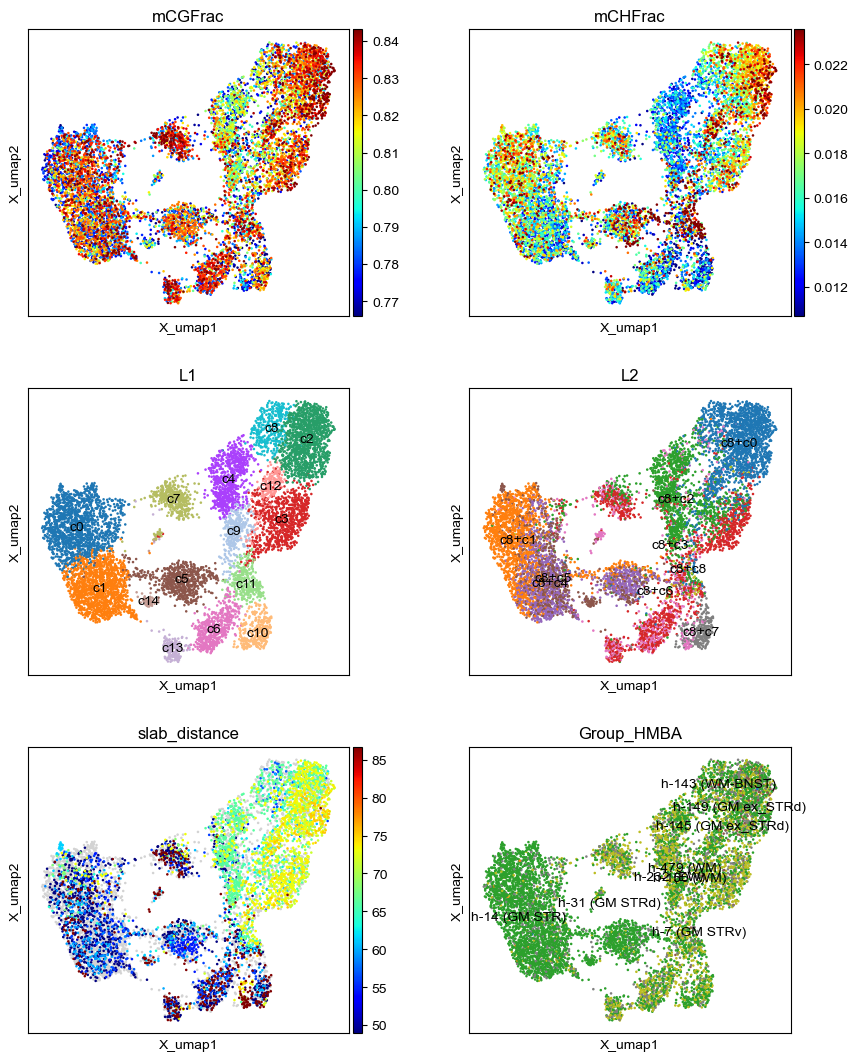

In [39]:
adata.obs['L2']=adata.obs['cluster_id'].apply(lambda x:"+".join(x.split('+')[:2]))
plt.figure()
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata,basis=basis,color=['mCGFrac','mCHFrac','L1','L2','slab_distance',clustering_name_annot+'_HMBA'],
               wspace=0.25,ncols=2,show=False,
               legend_loc='on data',use_raw=False,
               vmin='p5',vmax='p95',
               cmap='jet' #vcenter='p50'
              )
# plt.savefig(f"{fig_basename}.{coord_base}.obs_cols.pdf",bbox_inches='tight',dpi=300)
plt.show()

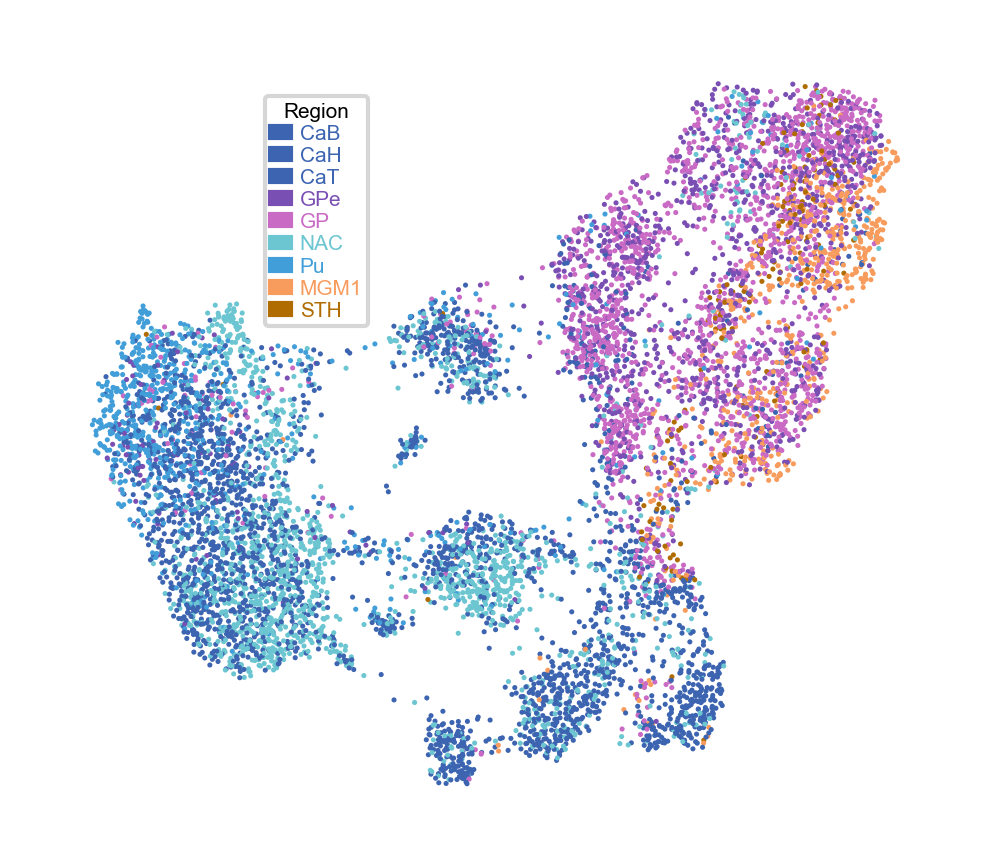

In [51]:
adata.obs['Region']=adata.obs['Region'].apply(lambda x:x if x != 'SubTH' else 'STH')
region_color_map={
        "CaB": "#3C64B1",
        "CaH": "#3C64B1",
        "CaT": "#3C64B1",
        "Eca": "#EB4C88",
        "GPe": "#7A4FB4",
        "GP": "#C96AC4", 
        "NAC": "#6BC6D1",
        "Pu": "#419ED9",
        "MGM1": "#F89C5E", 
        "STH": "#B06C00", 
        "VeP": "#3DBE78",
}
plot_cluster(adata_path=adata,coord_base='umap',cluster_col='Region',coding=False,text_anno=None,
             legend_kws=dict(bbox_to_anchor=(0.25,0.92)),axis_format=None,rectangle_marker=True,
             output=f"{fig_basename}.annotated.umap.Region.pdf",palette_path=region_color_map)

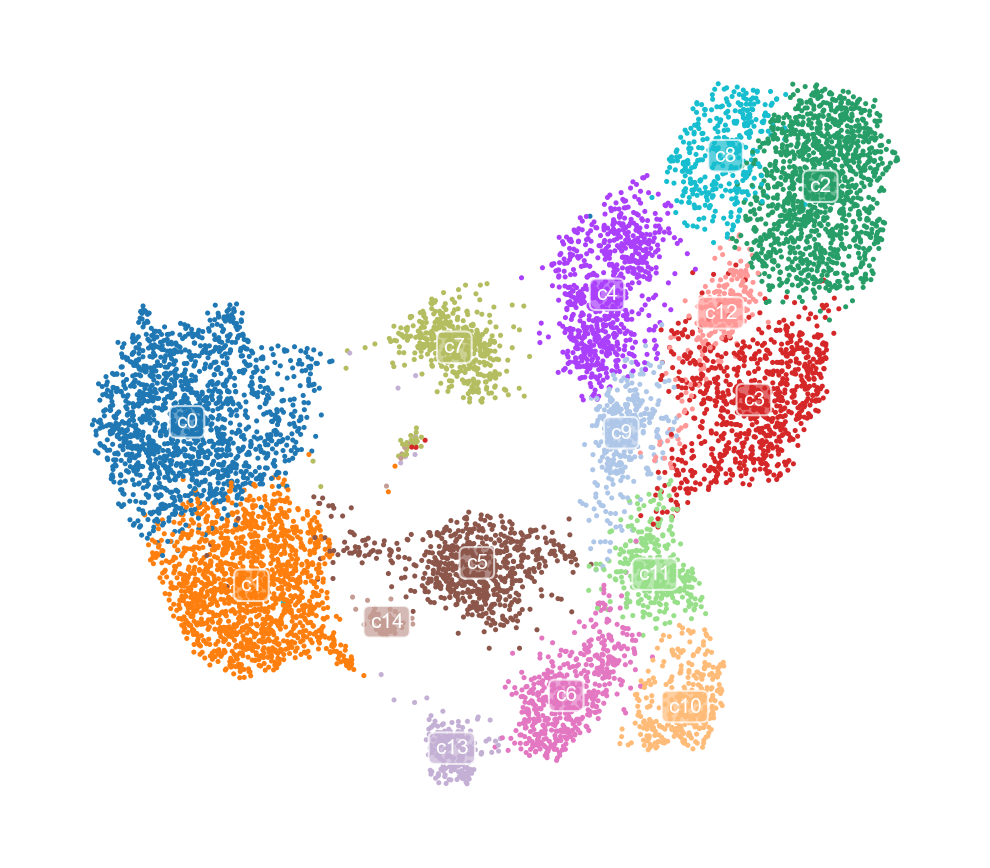

In [14]:
plot_cluster(adata_path=adata,coord_base='umap',cluster_col='L1',
             legend_kws=dict(bbox_to_anchor=(0.25,0.95)),axis_format=None,
    coding=False,fontsize=5,output=f"{fig_basename}.annotated.umap.L1.pdf",show_legend=False,
    palette_path=None)

## Manually Cell Type Mapping

In [52]:
print([col.replace('_score','') for col in adata.obs.columns if col.endswith('_score')])

['Nonneuron', 'Glut', 'Subpallium GABA', 'OPC', 'COP', 'Oligodendrocyte', 'Vascular', 'Immune', 'Microglia', 'Lymphocyte', 'Macrophage', 'Astrocyte', 'Endo', 'VLMC', 'VLMC-Pia', 'Pericyte', 'SMC', 'GM STR', 'WM', 'GM exSTRd', 'ImAstro']


In [53]:
# L3
ct_mapping={
    'GM STR': ['c0','c1','c5','c14'], 
     'GM exSTR': ['c2','c8'], 
     'WM': ['c3', 'c4','c7','c9','c12','c6','c10','c11','c13'], 
}

In [54]:
CTMD={}
for ct in ct_mapping:
    for cluster in ct_mapping[ct]:
        if cluster not in CTMD:
            CTMD[cluster]=ct
        else:
            CTMD[cluster]=CTMD[cluster]+','+ct
adata.obs['ASC_Group']=adata.obs[clustering_name].map(CTMD)
adata.strings_to_categoricals()
adata.obs['ASC_Group'].value_counts()

ASC_Group
WM          3772
GM STR      3549
GM exSTR    1508
Name: count, dtype: int64

### Plot cell types

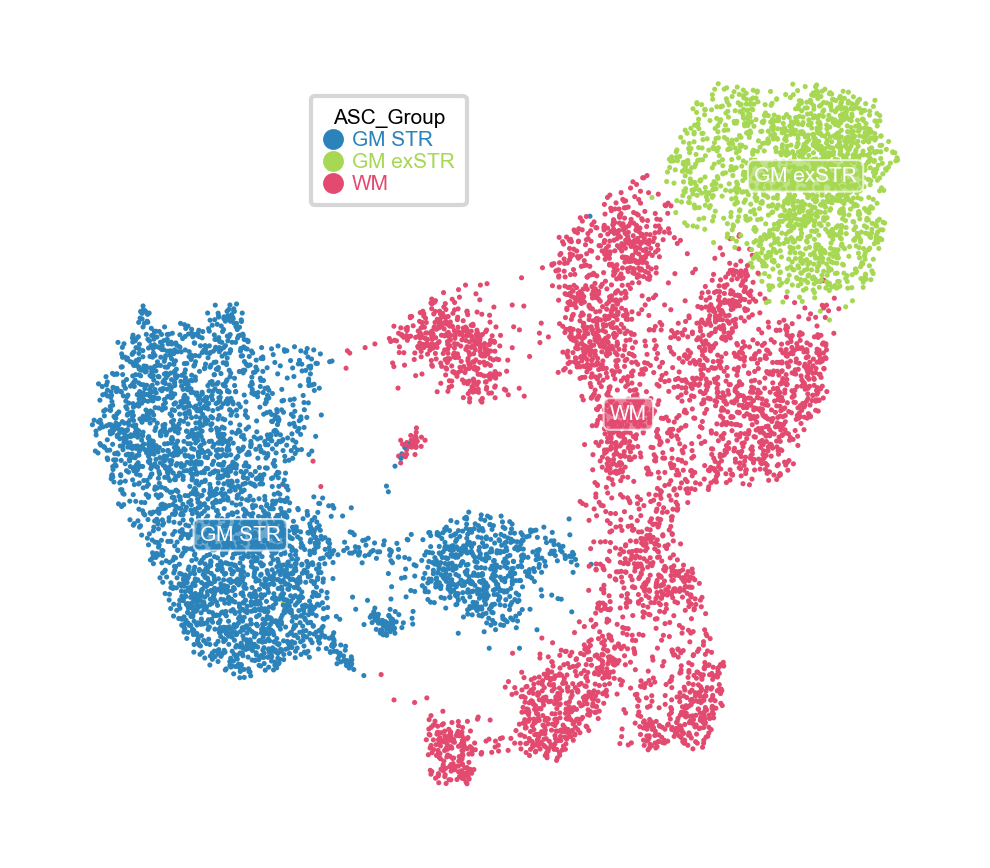

In [55]:
# group_colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name='ASC',index_col=0).Hex.to_dict()
group_colors={'GM STR':"#2B83BA",
'GM exSTR': "#A6D854",
'WM':"#E24A6F"}

plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col='ASC_Group',axis_format=None,
             coding=False,palette_path=group_colors,legend_kws=dict(bbox_to_anchor=(0.3,0.92)),
             output=f"{fig_basename}.annotated.{coord_base}.ASC_Group.pdf")
             #text_anno=None, outline=clustering_name_annot, outline_kws = {"linewidth": 0.5,"palette": colors, "c": "lightgray","single_contour_pad": 0.1},

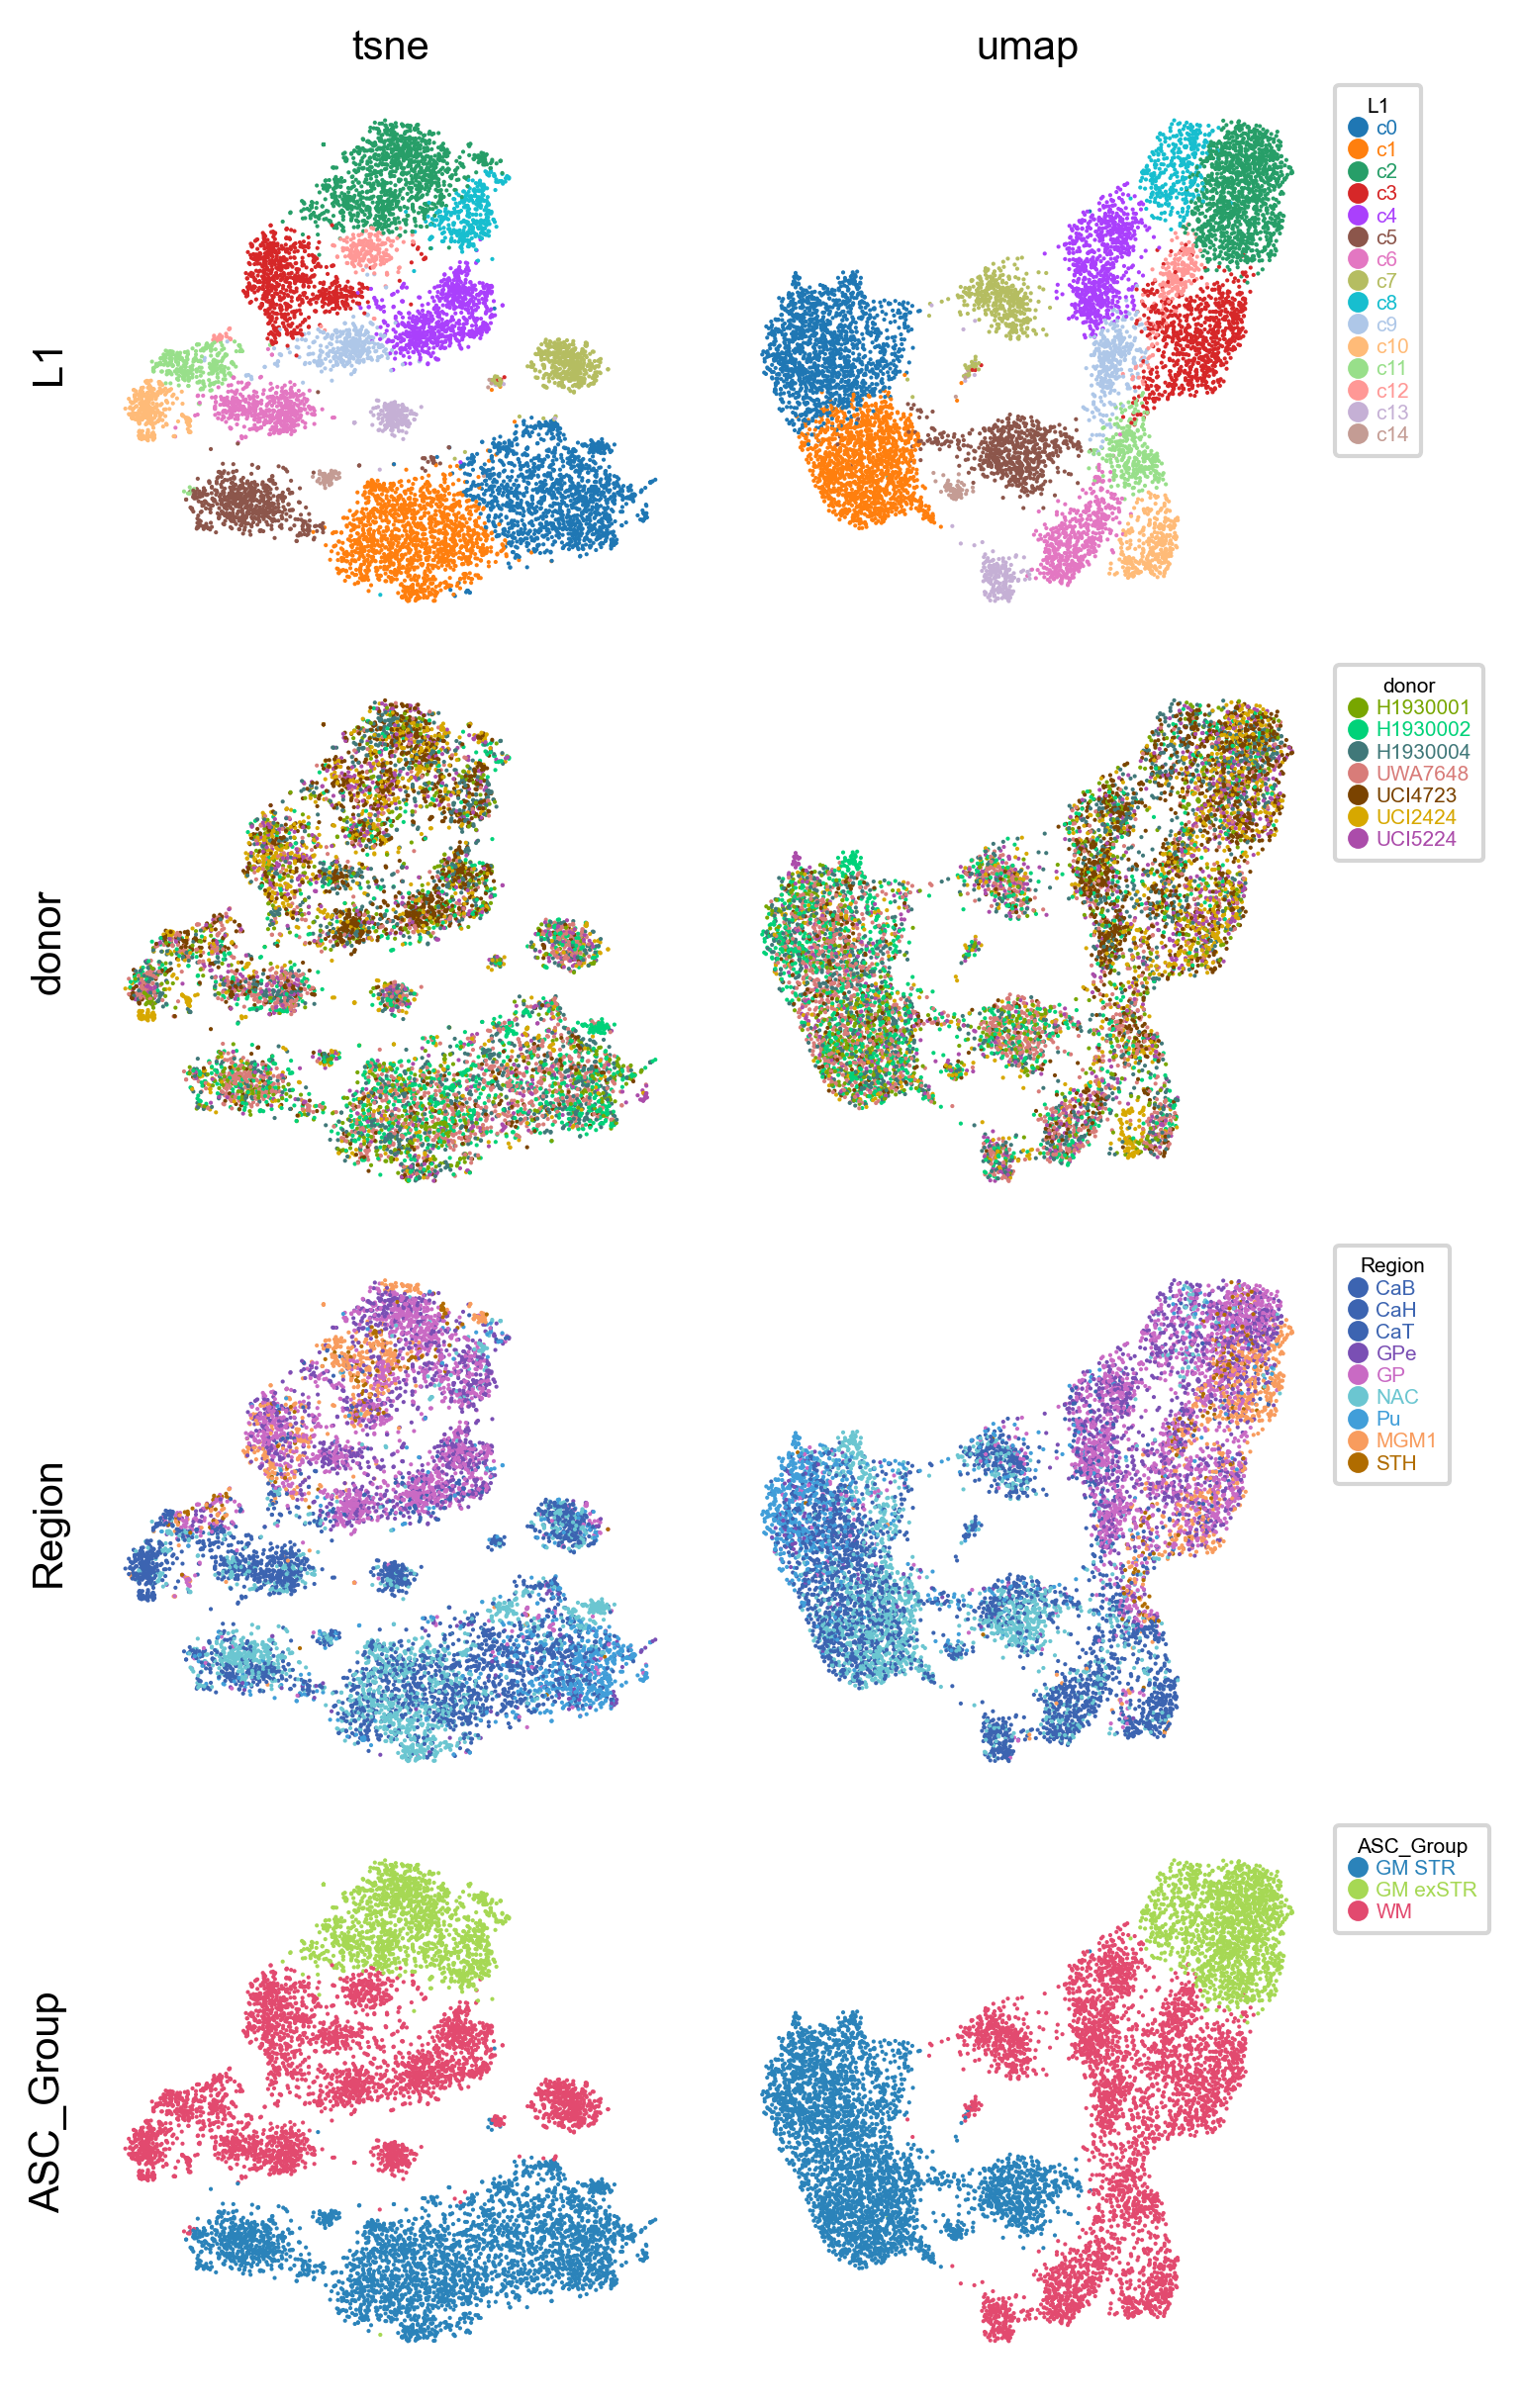

In [23]:
basises=['tsne','umap'] # columns
selected_cols=['L1','donor','Region','ASC_Group'] #rows
nrows=len(selected_cols)
ncols=len(basises)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(ncols * 2.5, nrows * 2), dpi=300,
                         constrained_layout=True,gridspec_kw=dict(wspace=-0.05,hspace=-0.05))
for i,col in enumerate(selected_cols):
    for j,basis1 in enumerate(basises):
        ax=axes[i,j]
        show_legend = True if (j + 1) == ncols else False
        if col=='ASC_Group':
            colors=group_colors
        elif col=='Region':
            colors=region_color_map
        else:
            colors=palette_path if col not in ['GM_WM_location','leiden','L1'] else None
        plot_cluster(adata_path=adata,coord_base=basis1,cluster_col=col,
             ax=ax,coding=False,palette_path=colors,
             output=None,show_legend=show_legend,legend_fontsize=5,fontsize=6,
            text_anno=None,show=False,axis_format=None)
        if i==0:
            ax.set_title(basis1, fontsize=10)
        if j==0:
            ax.set_ylabel(col, fontsize=10)
        # ax.axis('off')
plt.tight_layout()
plt.savefig(f"{fig_basename}.obs_cols.clustering.pdf", dpi=300, bbox_inches='tight')  #
plt.show()

In [58]:
ct_mapping

{'GM STR': ['c0', 'c1', 'c5', 'c14'],
 'GM exSTR': ['c2', 'c8'],
 'WM': ['c3', 'c4', 'c7', 'c9', 'c12', 'c6', 'c10', 'c11', 'c13']}

<Figure size 640x480 with 0 Axes>

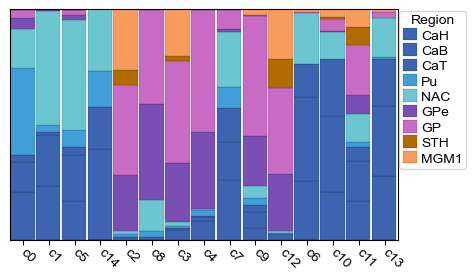

Region       CaB       CaH       CaT        GP       GPe      MGM1       NAC  \
L1                                                                             
c0      0.128591  0.207934  0.030780  0.034200  0.049248  0.001368  0.166895   
c1      0.219512  0.234577  0.015782  0.002152  0.006456  0.000000  0.494261   
c2      0.010274  0.002568  0.000856  0.390411  0.243151  0.261130  0.013699   
c3      0.043646  0.002567  0.006418  0.437741  0.258023  0.202824  0.015404   
c4      0.020804  0.081831  0.001387  0.528433  0.335645  0.001387  0.004161   
c5      0.197749  0.170418  0.033762  0.022508  0.020900  0.001608  0.475884   
c6      0.364008  0.255624  0.143149  0.006135  0.000000  0.010225  0.220859   
c7      0.167064  0.260143  0.145585  0.081146  0.014320  0.000000  0.238663   
c8      0.008824  0.002941  0.000000  0.405882  0.417647  0.000000  0.135294   
c9      0.066465  0.054381  0.033233  0.516616  0.220544  0.024169  0.051360   
c10     0.330189  0.207547  0.248428  0.053459  0.003145  0.034591  0.116352   
c11     0.170569  0.170569  0.063545  0.217391  0.080268  0.076923  0.123746   
c12     0.026201  0.000000  0.000000  0.371179  0.248908  0.213974  0.008734   
c13     0.304813  0.278075  0.203209  0.026738  0.000000  0.010695  0.171123   
c14     0.394366  0.000000  0.183099  0.000000  0.000000  0.000000  0.267606   

Region        Pu       STH  
L1                          
c0      0.378933  0.002052  
c1      0.027260  0.000000  
c2      0.012842  0.065068  
c3      0.010270  0.023107  
c4      0.026352  0.000000  
c5      0.075563  0.001608  
c6      0.000000  0.000000  
c7      0.090692  0.002387  
c8      0.026471  0.002941  
c9      0.027190  0.006042  
c10     0.000000  0.006289  
c11     0.020067  0.076923  
c12     0.004367  0.126638  
c13     0.005348  0.000000  
c14     0.154930  0.000000

In [57]:
from pym3c.plot import stacked_barplot
colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name='Region',index_col=0).Hex.to_dict()
# GM STR, exclude STR, WM
stacked_barplot(Input=adata.obs,column='Region',
                groupby='L1',width=5,height=3,
                x_order=ct_mapping['GM STR'] + ct_mapping['GM exSTR']+ct_mapping['WM'],
                y_order=['CaH','CaB','CaT', 'Pu', 'NAC', 'GPe', 'GP', 'STH', 'MGM1'],
                outdir=figdir,palette=region_color_map)
df=adata.obs.groupby('L1')['Region'].value_counts(normalize=True).reset_index()
df=df.pivot_table(index='L1',columns='Region',values='proportion')
df

<Figure size 640x480 with 0 Axes>

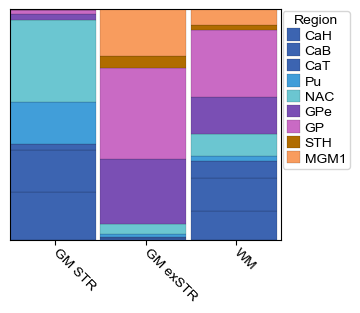

Region          CaB       CaH       CaT        GP       GPe      MGM1  \
ASC_Group                                                               
GM STR     0.181741  0.207664  0.028459  0.018879  0.026486  0.000845   
GM exSTR   0.009947  0.002653  0.000663  0.393899  0.282493  0.202255   
WM         0.142630  0.127784  0.075292  0.292153  0.160127  0.068134   

Region          NAC        Pu       STH  
ASC_Group                                
GM STR     0.351648  0.183150  0.001127  
GM exSTR   0.041114  0.015915  0.051061  
WM         0.092259  0.021739  0.019883

In [59]:
from pym3c.plot import stacked_barplot
colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name='Region',index_col=0).Hex.to_dict()
# reorder regions: Ca, Pu, NAC, GPe, GP, STH, MGM1 
stacked_barplot(Input=adata.obs,column='Region',
                groupby='ASC_Group',width=3.5,height=3,
                y_order=['CaH','CaB','CaT', 'Pu', 'NAC', 'GPe', 'GP', 'STH', 'MGM1'],
                outdir=figdir,palette=region_color_map)
df=adata.obs.groupby('ASC_Group')['Region'].value_counts(normalize=True).reset_index()
df=df.pivot_table(index='ASC_Group',columns='Region',values='proportion')
df

L1
c1     54.288032
c5     57.009672
c0     57.427786
c6     61.367891
c7     63.480560
c8     64.411879
c11    64.494932
c4     64.910503
c13    64.930636
c9     66.228715
c10    69.180992
c12    69.860040
c2     69.969890
c3     70.210149
c14    73.565179
Name: slab_distance, dtype: float64

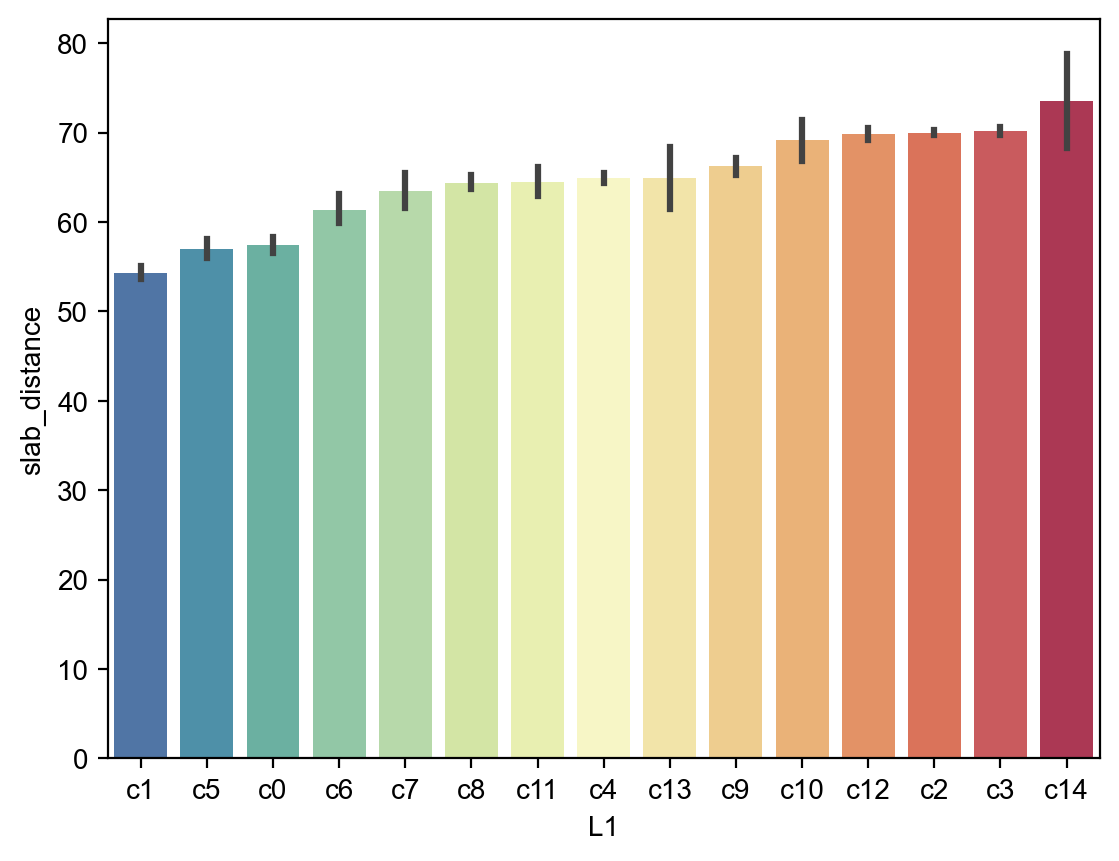

In [105]:
import seaborn as sns
df=adata.obs.loc[:,['L1','slab_distance']]
df1=df.groupby('L1')['slab_distance'].mean().sort_values()
sns.barplot(df,x='L1',y='slab_distance',palette="Spectral_r",
            order=df1.index.tolist()
           )
df1

In [106]:
# Plot dot heatmap for the fraction of cells in each cell type for each time point
col1="L1"
col2='Region'
df=adata.obs.loc[:,[col1,col2]].value_counts().unstack().apply(lambda x:x / x.sum())
# df.columns=[clustering_name_annot,col,'fraction']
df

Region       CaB       CaH       CaT        GP       GPe      MGM1       NAC  \
L1                                                                             
c0      0.156928  0.248569  0.116580  0.028361  0.064057  0.003540  0.147165   
c1      0.255426  0.267375  0.056995  0.001702  0.008007       NaN  0.415561   
c2      0.010017  0.002453  0.002591  0.258650  0.252669  0.539823  0.009650   
c3      0.028381  0.001635  0.012953  0.193420  0.178826  0.279646  0.007238   
c4      0.012521  0.048242  0.002591  0.216109  0.215302  0.001770  0.001809   
c5      0.102671  0.086672  0.054404  0.007941  0.011566  0.001770  0.178528   
c6      0.148581  0.102208  0.181347  0.001702       NaN  0.008850  0.065139   
c7      0.058431  0.089125  0.158031  0.019285  0.005338       NaN  0.060314   
c8      0.002504  0.000818       NaN  0.078276  0.126335       NaN  0.027744   
c9      0.018364  0.014718  0.028497  0.096994  0.064947  0.014159  0.010253   
c10     0.087646  0.053966  0.204663  0.009643  0.000890  0.019469  0.022316   
c11     0.042571  0.041701  0.049223  0.036869  0.021352  0.040708  0.022316   
c12     0.005008       NaN       NaN  0.048213  0.050712  0.086726  0.001206   
c13     0.047579  0.042518  0.098446  0.002836       NaN  0.003540  0.019300   
c14     0.023372       NaN  0.033679       NaN       NaN       NaN  0.011460   

Region        Pu     SubTH  
L1                          
c0      0.732804  0.019231  
c1      0.050265       NaN  
c2      0.019841  0.487179  
c3      0.010582  0.115385  
c4      0.025132       NaN  
c5      0.062169  0.006410  
c6           NaN       NaN  
c7      0.050265  0.006410  
c8      0.011905  0.006410  
c9      0.011905  0.012821  
c10          NaN  0.012821  
c11     0.007937  0.147436  
c12     0.001323  0.185897  
c13     0.001323       NaN  
c14     0.014550       NaN

Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


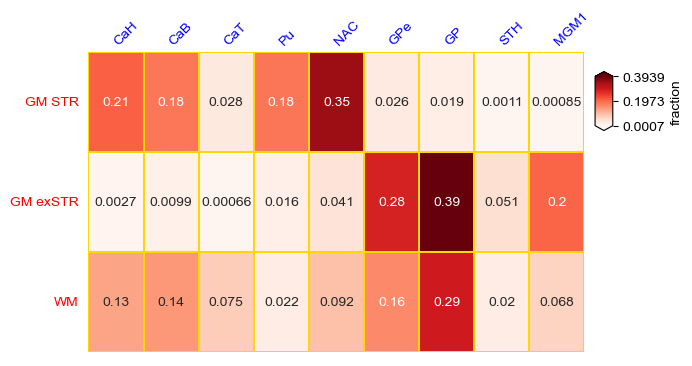

In [62]:
from PyComplexHeatmap import *
plt.figure(figsize=(6.5,3.5))
ClusterMapPlotter(
    df.loc[:,['CaH','CaB','CaT', 'Pu', 'NAC', 'GPe', 'GP', 'STH', 'MGM1']],row_cluster=False,col_cluster=False,cmap='Reds',
    # left_annotation=left_ha,right_annotation=right_ha,
    # row_split=df_rows.Neighborhood,row_split_gap=0.5,
    show_rownames=True,show_colnames=True,col_names_side='top',row_names_side='left',
    yticklabels=True,xticklabels=True,
    xticklabels_kws=dict(labelrotation=45,labelcolor='blue',labelsize=10),
    yticklabels_kws=dict(labelcolor='red',labelsize=10),
    # ylabel="L1",
    annot=True,fmt='.2g',linewidth=0.05,linecolor='gold',linestyle='-:',
    label='fraction',legend_kws=dict(extend='both',extendfrac=0.1),
)
# plt.savefig(f"{fig_basename}.cell_type_distriution_across_{col}.pdf",bbox_inches='tight',dpi=300)
plt.show()

### Write metadata for each cell types

In [108]:
print(run_annotation,run_clustering,clustering_name,cluster_col)

True True L1 L1


In [109]:
adata.strings_to_categoricals()
adata.obs.to_csv(f"{data_basename}.obs.tsv",sep='\t')
if run_clustering:
    adata.write_h5ad(f"{data_basename}.clustered.h5ad")
else:
    adata.write_h5ad(f"{data_basename}.annotated.h5ad")